# 2.0 Train model and save the results

Setup

In [1]:
import torch

In [2]:
device = torch.device("cuda") if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"

print(f"Using device: {device}")

Using device: cuda


## Prepare data

Define dataset parameters and transforms

In [3]:
from torchvision import transforms

# train_mean = [0.3186241388320923, 0.2931755483150482, 0.3017965853214264]
# train_std = [0.2762017846107483, 0.2654302418231964, 0.2686000168323517]

train_mean = [0.5, 0.5, 0.5]
train_std = [0.5, 0.5, 0.5]


class ContrastStretch(object):
    def __call__(self, img):
        # img: Tensor [C,H,W] in [0,1]
        lo, hi = img.min(), img.max()
        return (img - lo) / (hi - lo + 1e-5)

transform = transforms.Compose([
    transforms.ToTensor(),
    ContrastStretch(),
    transforms.Normalize(mean=train_mean, std=train_std),
])

Load the dataset

In [4]:
from torchvision.datasets import ImageFolder

# train_dir = "./data/train_upsampled"
train_dir = "./data/train"
train_ds = ImageFolder(train_dir, transform=transform)

num_classes = len(train_ds.classes)

print(f"Number of train images: {len(train_ds)}")
print(f"Number of train classes: {num_classes}")

Number of train images: 31367
Number of train classes: 43


Prepare data loaders

In [5]:
from torch.utils.data import DataLoader

batch_size = 256

train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)

Add weighted loader

In [6]:
import numpy as np
from torch.utils.data import DataLoader, WeightedRandomSampler
from collections import Counter

targets = train_ds.targets 
class_counts = Counter(targets)
num_samples = len(targets)

class_weights = {cls: 1.0/count for cls, count in class_counts.items()}

sample_weights = np.array([class_weights[t] for t in targets], dtype=np.float32)

sampler = WeightedRandomSampler(
    weights=sample_weights,     
    num_samples=int(num_samples * 1.5),  # oversample
    replacement=True
)

rebalanced_train_dl = DataLoader(
    train_ds,
    batch_size=batch_size,
    sampler=sampler,
    shuffle=False,
)

## Create model

Define the latent space

In [7]:
latent_dim = 128

Define the model

In [8]:
from gnn import Generator, Discriminator

generator = Generator(num_classes, latent_dim=latent_dim).to(device)
discriminator = Discriminator(num_classes).to(device)

## Train model

Initialize weights

In [9]:
import torch.nn as nn

def weights_init(m):
    if isinstance(m, (nn.Conv2d, nn.Linear)):
        nn.init.normal_(m.weight, 0.0, 0.02)
        if m.bias is not None:
            nn.init.zeros_(m.bias)
    elif isinstance(m, nn.BatchNorm2d):
        nn.init.normal_(m.weight, 1.0, 0.02)
        nn.init.zeros_(m.bias)


generator.apply(weights_init)
discriminator.apply(weights_init)

Discriminator(
  (conv_in): Conv2d(3, 256, kernel_size=(1, 1), stride=(1, 1))
  (res_dn1): Sequential(
    (0): ResBlock(
      (conv1): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (act): ReLU()
    )
    (1): AvgPool2d(kernel_size=2, stride=2, padding=0)
  )
  (res_dn2): Sequential(
    (0): ResBlock(
      (conv1): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats

Define training parameters

In [10]:
import torch.optim as optim
import torch.nn as nn

G_lr = 1e-4
D_lr = 1e-4

# Optimizers
generator_optimizer = torch.optim.Adam(generator.parameters(), lr=G_lr)
generator_scheduler = optim.lr_scheduler.ExponentialLR(optimizer=generator_optimizer, gamma=0.99)
discriminator_optimizer = torch.optim.Adam(discriminator.parameters(), lr=D_lr)
discriminator_scheduler = optim.lr_scheduler.ExponentialLR(optimizer=discriminator_optimizer, gamma=0.99)

# loss
adv_criterion = nn.BCEWithLogitsLoss()

Train the model

Epoch 1: 100%|██████████| 184/184 [01:09<00:00,  2.64it/s]


Epoch 1: D(real)=0.938  D(fake)=0.059  D_loss=8.495  G_loss=255.680


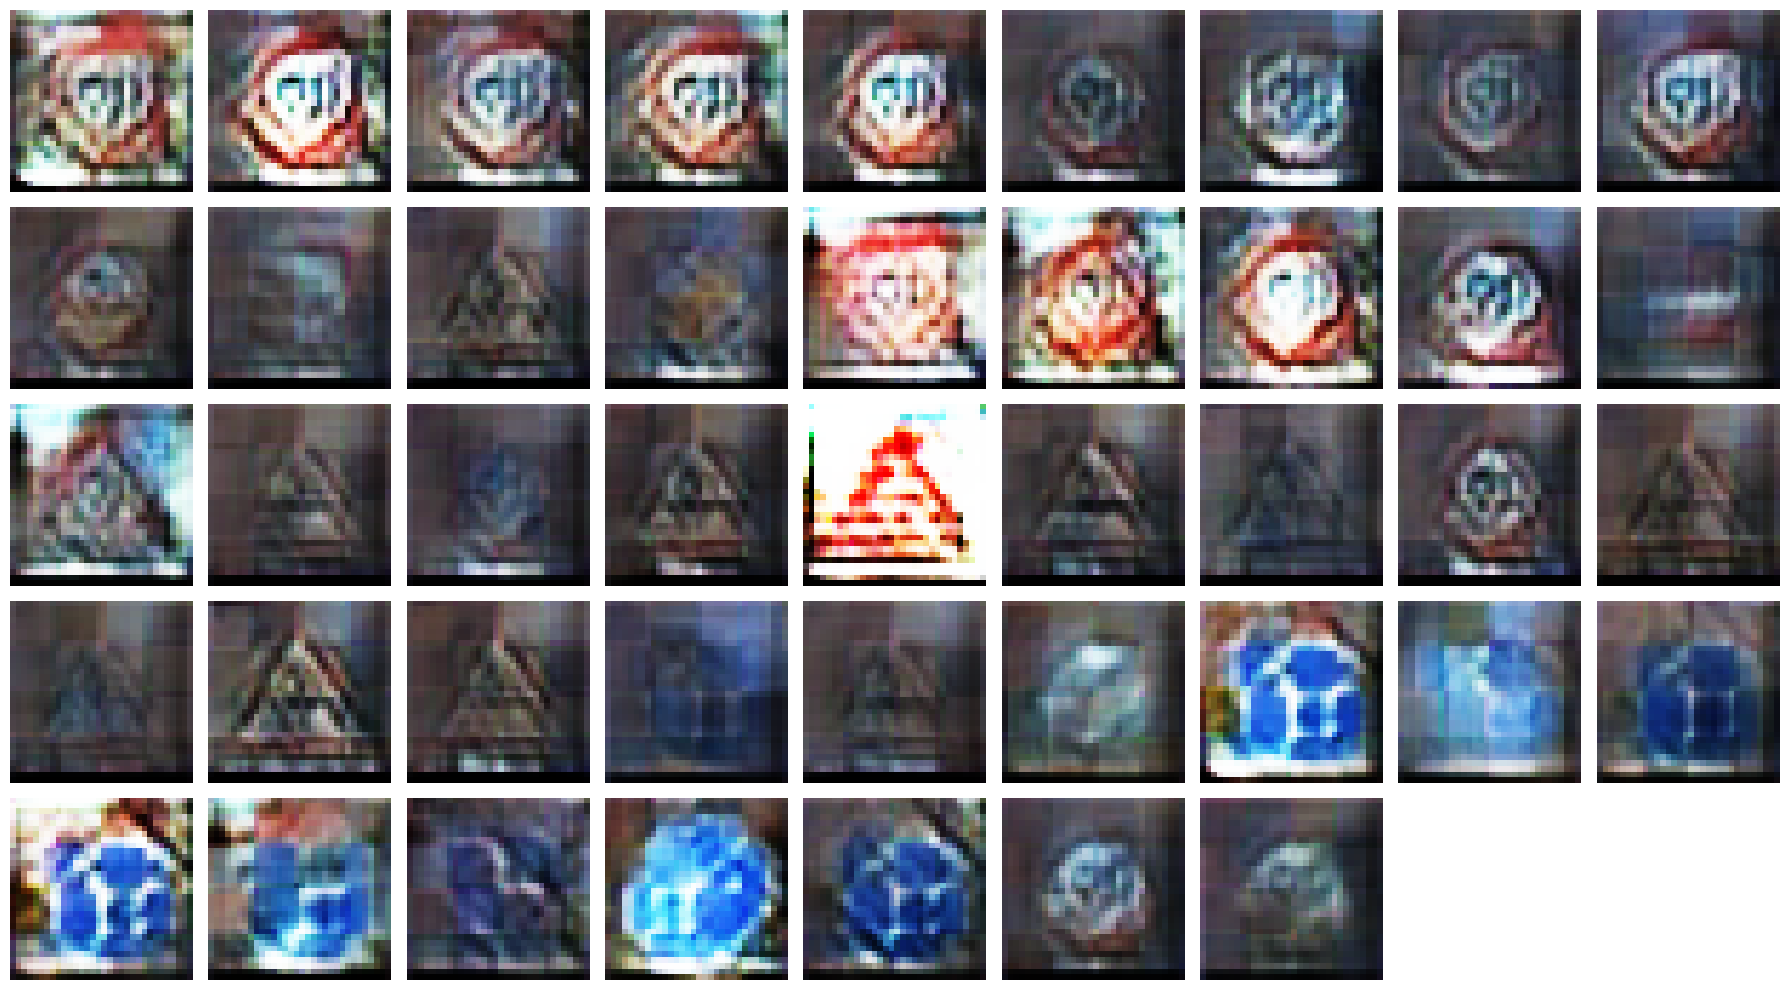

Epoch 2: 100%|██████████| 184/184 [01:09<00:00,  2.65it/s]


Epoch 2: D(real)=0.944  D(fake)=0.052  D_loss=6.555  G_loss=237.707


Epoch 3:  72%|███████▏  | 133/184 [00:50<00:19,  2.65it/s]

In [ ]:
from gnn import Trainer as GNNTrainer

gnn_trainer = GNNTrainer(num_classes, adversarial_criterion=adv_criterion, latent_dim=latent_dim, device=device)
gnn_trainer.set_generator(generator, generator_optimizer, generator_scheduler)
gnn_trainer.set_discriminator(discriminator, discriminator_optimizer, discriminator_scheduler)

# Training
loss = gnn_trainer.fit(rebalanced_train_dl, num_epochs=250, mean=train_mean, std=train_std)

train further

In [ ]:
loss = gnn_trainer.fit(rebalanced_train_dl, num_epochs=100, mean=train_mean, std=train_std)

save the model

In [ ]:
# Save generator and discriminator weights
import os

weights_dir = "./gnn/weights"

os.makedirs(weights_dir, exist_ok=True)

gen_path = os.path.join(weights_dir, "generator_bigger.pth")
disc_path = os.path.join(weights_dir, "discriminator_bigger.pth")

torch.save(generator.state_dict(), gen_path)
torch.save(discriminator.state_dict(), disc_path)

print(f"Generator weights saved to: {gen_path}")
print(f"Discriminator weights saved to: {disc_path}")

## Evaluation

Load test dataset

In [ ]:
test_dir = "./data/test"
test_ds = ImageFolder(test_dir)

Generate samples and save them to results folder

In [ ]:
import os
import time

from collections import Counter
from torchvision.utils import save_image


results_id = time.time()
results_dir = f"./results/{results_id}"

os.makedirs(results_dir, exist_ok=True)

class_counts = Counter(test_ds.targets)

mean_t = torch.tensor(train_mean).view(1, 3, 1, 1).to(device)
std_t = torch.tensor(train_std).view(1, 3, 1, 1).to(device)

generator.eval()

for cls, cnt in class_counts.items():
    for i in range(cnt):
        z = torch.randn(1, latent_dim, device=device)
        labels = torch.tensor([cls], device=device)
        with torch.no_grad():
            img = generator(z, labels)

        img = img * std_t + mean_t

        fname = os.path.join(results_dir, f"{cls}_{i}.jpg")
        save_image(img.clamp(0, 1), fname)

Calculate the FID between test set and generated images

In [ ]:
from pytorch_fid.fid_score import calculate_fid_given_paths

test_flat_dir = "./data/test_flat"
generated_dir = results_dir

fid = calculate_fid_given_paths([test_flat_dir, generated_dir], batch_size, device, dims=2048, num_workers=1)

print(f"FID: {fid}")